**INITIALIZATION**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [1]:
#@ INITIALIZATION: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**LIBRARIES AND DEPENDENCIES**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [3]:
#@ INSTALLING DEPENDENCIES: UNCOMMENT BELOW: 
# !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [4]:
#@ DOWNLOADING LIBRARIES AND DEPENDENCIES: 
from fastbook import *                                  # Getting all the Libraries. 
from fastai.callback.fp16 import *
from fastai.vision.all import *                         # Getting all the Libraries.
#@ IGNORING WARNINGS: 
import warnings
warnings.filterwarnings("ignore")

**GETTING THE DATA**
- I will use **Imagenette** dataset here. 

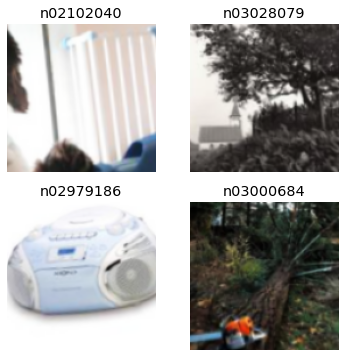

In [6]:
#@ FUNCTION FOR PREPARING THE DATASET: 
def get_data(url, presize, resize):                                         # Defining Function. 
    path = untar_data(url)                                                  # Initializing Path to Dataset. 
    return DataBlock(blocks=(ImageBlock, CategoryBlock),                    # Initilizing DataBlocks. 
                     get_items=get_image_files,                             # Getting Image Files. 
                     splitter=GrandparentSplitter(valid_name="val"),        # Splitting the Dataset. 
                     get_y=parent_label, item_tfms=Resize(resize),          # Initializing Transformations. 
                     batch_tfms=[*aug_transforms(min_scale=0.5,size=resize), 
                                 Normalize.from_stats(*imagenet_stats)]     # Normalizing the Dataset. 
                     ).dataloaders(path, bs=128)                            # Initializing DataLoaders. 

#@ INITIALIZING DATALOADERS: 
dls = get_data(URLs.IMAGENETTE_160, 160, 128)                               # Implementation of Function. 
dls.show_batch(max_n=4)                                                     # Inspecting the Data. 

In [7]:
#@ INITIALIZING RESNET34 WITHOUT PRETRAINING: BASELINE MODEL: 
def get_learner(**kwargs):                                                 # Defining Function. 
    return cnn_learner(dls, resnet34, pretrained=False,                    # Initializing ResNet Model. 
                       metrics=accuracy, **kwargs).to_fp16()               # Initializing Learner.

In [8]:
#@ TRAINING THE MODEL WITH DEFAULT OPTIMIZER: 
learn = get_learner()                                                      # Initializing Learner. 
learn.fit_one_cycle(3, 3e-3)                                               # Training the Model. 

epoch,train_loss,valid_loss,accuracy,time
0,2.539755,4.393148,0.265987,01:15
1,2.005960,1.791044,0.409172,01:16
2,1.690481,1.417862,0.543185,01:15


SuggestedLRs(valley=0.009120108559727669)

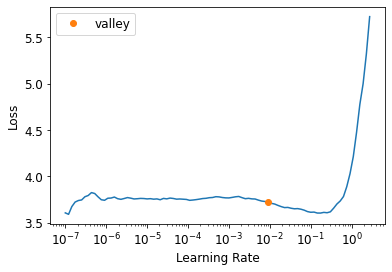

In [9]:
#@ TRAINING THE MODEL WITH SGD OPTIMIZER: 
learn = get_learner(opt_func=SGD)                                          # Initializing Learner. 
learn.lr_find()                                                            # Inspecting Optimal LR. 

In [10]:
#@ TRAINING THE MODEL: 
learn.fit_one_cycle(3, 0.03, moms=(0,0,0))                                 # Training the Model. 

epoch,train_loss,valid_loss,accuracy,time
0,2.904688,2.175231,0.270064,01:14
1,2.368949,1.858777,0.357197,01:14
2,2.140049,1.734714,0.412484,01:14


**GENERIC OPTIMIZER**

In [11]:
#@ FUNCTIONS FOR OPTIMIZER CLASS: 
def zero_grad(self):                                      # Defining Function. 
    for p, *_ in self.all_params():                       # Looping through Parameters. 
        p.grad.detach_()                                  # Removing History of Gradients. 
        p.grad.zero_()                                    # Setting Gradients to Zero. 

def step(self):                                           # Defining Function. 
    for p, pg, state, hyper in self.all_params():         # Looping through Parameters. 
        for cb in self.cbs:                               # Looping through Callbacks. 
            state = _update(state, 
                            cb(p,**{**state,**hyper}))    # Updating the Parameters. 
        self.state[p] = state

def sgd_cb(p, lr, **kwargs):                              # Defining Function. 
    p.data.add_(-lr, p.grad.data)                         # Initializing Multiplication and Addition. 

#@ INITIALIIZNG OPTIMIZATION FUNCTION: 
opt_func = partial(Optimizer, cbs=[sgd_cb])               # Initialization. 

In [12]:
#@ TRAINING THE MODEL WITH SGD OPTIMIZER: 
learn = get_learner(opt_func=opt_func)                    # Initializing the Learner.
learn.fit(3, 0.03)                                        # Training the Model.  

epoch,train_loss,valid_loss,accuracy,time
0,2.632093,2.003972,0.354904,01:14
1,2.245025,1.819269,0.405860,01:14
2,2.017838,1.603688,0.487134,01:15


**MOMENTUM**

In [13]:
#@ IDEA OF MOMENTUM: UNCOMMENT BELOW: 
# weight.avg = beta * weight.avg + (1-beta) * weight.grad
# new_weight = weight - lr * weight.avg

In [14]:
#@ FUNCTION TO TRACK GRADIENT AVERAGES: 
def average_grad(p, mom, grad_avg=None, **kwargs):           # Defining Function. 
    if grad_avg is None:                            
        grad_avg = torch.zeros_like(p.grad.data)             # Initializing Zero Gradients. 
    return {"grad_avg": grad_avg*mom + p.grad.data}          # Getting Average of Gradients. 

#@ DEFINING MOMENTUM FUNCTION: 
def momentum_step(p, lr, grad_avg, **kwargs):                # Defining Function. 
    p.data.add_(-lr, grad_avg)                               # Getting Average of Gradients. 
opt_func = partial(Optimizer, 
                   cbs=[average_grad,momentum_step],mom=0.9) # Initializing Optimizer Function. 

In [15]:
#@ TRAINING THE MODEL WITH SGD OPTIMIZER: 
learn = get_learner(opt_func=opt_func)                       # Initializing the Learner.
learn.fit(3, 0.03)                                           # Training the Model.  

epoch,train_loss,valid_loss,accuracy,time
0,2.629264,1.999854,0.281529,01:14
1,2.384013,1.841031,0.372994,01:13
2,2.321460,2.641702,0.375287,01:14


In [17]:
#@ IDEA OF RMS PROP OPTIMIZATION FUNCTION: 
# w.square_avg = alpha * w.square_avg + (1-alpha) * (w.grad**2)
# new_w = w - lr * w.grad / math.sqrt(w.square_avg + eps)

In [19]:
#@ FUNCTION TO TRACK SQUARED GRADIENT AVERAGES: 
def average_sqr_grad(p,sqr_mom,sqr_avg=None,**kwargs):       # Defining Function. 
    if sqr_avg is None: 
        sqr_avg = torch.zeros_like(p.grad.data)              # Initializing Zero Gradients. 
    return {"sqr_avg": sqr_avg*sqr_mom + p.grad.data**2}     # Getting Squared Average of Gradients. 